# **💎 Language Modeling 💎**


# **1. Import Libs**

## **1-1. Install libraries**

In [ ]:
!rm -rf /content/sample_data

In [ ]:
pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 7.1 MB/s eta 0:00:00


In [ ]:
!pip install -q portalocker>=2.0.0

In [ ]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 28.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00


## **1-1. Import libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torchtext
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm
import wandb

import os
from collections import Counter

import ipywidgets as widgets
from IPython.display import display

In [ ]:
!python --version

Python 3.10.12


In [ ]:
for lib in [np, torch, torchtext, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.23.5
torch --> 2.1.0+cu118
torchtext --> 0.16.0+cpu
tqdm --> 4.66.1


#  **2. Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

Number of trainale parameters

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [ ]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **3. Arguments**

In [ ]:
seed = 8

batch_size = 80
seq_len = 70

embedding_dim = 400

num_layers = 3
hidden_dim = 1150

dropout_embd = 0.5
dropout_rnn = 0.0

lr = 8
wd = 1e-6
momentum = 0.9

clip = 0.25

wandb_enable = True

In [ ]:
wandb_arg_name = input('Please input the WandB argument (run) name:')

In [ ]:
wandb_arg_name

#  **4. Dataset**

##  **4-1. Download & Unzip the Dataset**

In [ ]:
train_iter, valid_iter, test_iter = WikiText2('/content/')

In [ ]:
train_iter_ = iter(train_iter)
train_iter_

<generator object ShardingFilterIterDataPipe.__iter__ at 0x7c10782bb370>

In [ ]:
next(train_iter_)

' \n'

## **4-2. Build vocabulary and save it**

🔰 In this section we need to:

*   Define a tokenizer using `basic_english`
*   Tokenize the dataset and collect tokens
*   Build the vocabulary using `build_vocab_from_iterator`
*   Manually insert special tokens and set the default index


In [ ]:
f_train = open('/content/datasets/WikiText2/wikitext-2/wiki_train_tokens.txt')

In [ ]:
f_train2 = f_train.readlines()

In [ ]:
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, f_train2), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [ ]:
len(vocab)

28782

In [ ]:
vocab(['saeideh', 'hi', 'how', 'tehran', 'ali', 'valkyria'])

[0, 9206, 416, 23311, 2284, 3849]

In [ ]:
torch.save(vocab, 'vocab.pt')

In [ ]:
!cp /content/vocab.pt /content/drive/MyDrive/Howsam_Language_Modeling

## **4-3. EDA**

**how many paragraph:**

In [ ]:
len(f_train2)

36718

In [ ]:
f_train2[3]

' Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . \n'

In [ ]:
main_tokens = list(map(tokenizer, f_train2))

In [ ]:
len(main_tokens)

36718

In [ ]:
vocab_dicts = {}
for i in main_tokens:
  for j in i:
    if j not in vocab_dicts.keys():
      vocab_dicts[j] = 1
    else:
      vocab_dicts[j] += 1

In [ ]:
len(vocab_dicts.keys())

28782

**all words in train.txt:**

In [ ]:
count_totall_word = 0
for i in main_tokens:
  for j in i:
    count_totall_word = count_totall_word + len(j)
count_totall_word

8618752

**Most and least common words:**

In [ ]:
# count = 0
count_dict2 = {}
for k, v in vocab_dicts.items():
  # count=count +1
  if v in count_dict2.keys():
    count_dict2[v]+=1
  else:
    count_dict2[v]=1

  # print(f"count {count}: ", k ," ", v)

In [ ]:
count_dict2

{29570: 1,
 54: 63,
 53: 63,
 231: 4,
 5: 2261,
 1702: 1,
 1601: 1,
 54625: 1,
 11992: 1,
 255: 6,
 3: 5130,
 102615: 1,
 29: 154,
 83397: 1,
 57030: 1,
 130768: 1,
 38: 91,
 12004: 1,
 119: 16,
 206: 8,
 39521: 1,
 15058: 1,
 309: 2,
 212: 7,
 11691: 1,
 36523: 1,
 32: 143,
 598: 1,
 16906: 1,
 342: 4,
 725: 2,
 2077: 1,
 429: 3,
 12718: 1,
 9: 991,
 50735: 1,
 262: 4,
 87: 35,
 13794: 1,
 124: 15,
 33: 105,
 979: 2,
 45015: 1,
 693: 2,
 519: 1,
 9273: 1,
 716: 1,
 1498: 1,
 45: 78,
 271: 5,
 2607: 1,
 103: 22,
 3877: 1,
 24: 206,
 545: 1,
 194: 7,
 66: 42,
 4242: 1,
 128: 22,
 12: 646,
 576: 1,
 197: 4,
 104: 22,
 2690: 1,
 1465: 1,
 1370: 1,
 3029: 1,
 113: 17,
 132: 9,
 624: 1,
 325: 2,
 4714: 1,
 1272: 1,
 93: 31,
 8: 1100,
 1102: 1,
 505: 2,
 611: 1,
 65: 52,
 2137: 1,
 856: 1,
 126: 16,
 1083: 2,
 180: 7,
 15140: 1,
 589: 3,
 2127: 1,
 181: 5,
 338: 1,
 3842: 1,
 46: 80,
 1584: 1,
 457: 2,
 2402: 1,
 641: 2,
 55: 61,
 70: 45,
 1448: 1,
 441: 2,
 9229: 1,
 407: 1,
 11: 686,
 957:

In [ ]:
from collections import OrderedDict
dict1 = OrderedDict(sorted(count_dict2.items()))
print(dict1)

OrderedDict([(3, 5130), (4, 3243), (5, 2261), (6, 1740), (7, 1389), (8, 1100), (9, 991), (10, 794), (11, 686), (12, 646), (13, 515), (14, 448), (15, 414), (16, 385), (17, 327), (18, 291), (19, 292), (20, 277), (21, 245), (22, 260), (23, 213), (24, 206), (25, 175), (26, 211), (27, 155), (28, 141), (29, 154), (30, 161), (31, 127), (32, 143), (33, 105), (34, 126), (35, 118), (36, 107), (37, 104), (38, 91), (39, 100), (40, 93), (41, 94), (42, 101), (43, 76), (44, 83), (45, 78), (46, 80), (47, 85), (48, 61), (49, 61), (50, 64), (51, 60), (52, 58), (53, 63), (54, 63), (55, 61), (56, 55), (57, 55), (58, 54), (59, 51), (60, 45), (61, 50), (62, 39), (63, 45), (64, 50), (65, 52), (66, 42), (67, 46), (68, 38), (69, 45), (70, 45), (71, 43), (72, 43), (73, 37), (74, 25), (75, 39), (76, 30), (77, 28), (78, 27), (79, 34), (80, 27), (81, 32), (82, 43), (83, 29), (84, 29), (85, 29), (86, 21), (87, 35), (88, 26), (89, 27), (90, 30), (91, 26), (92, 24), (93, 31), (94, 22), (95, 27), (96, 24), (97, 19), (

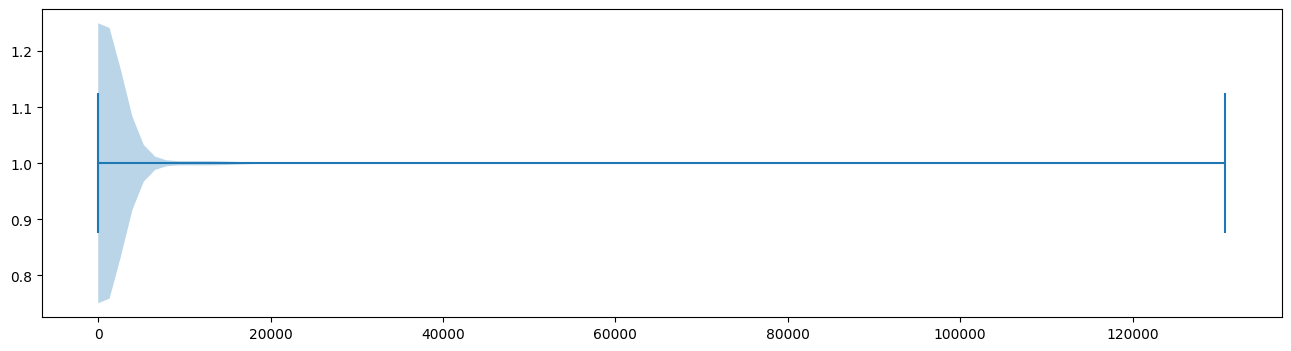

In [ ]:
plt.figure(figsize=(16, 4))
plt.violinplot(dict1, vert=False);

In [ ]:
freqs = Counter()
for tokens in map(tokenizer, f_train2):
  freqs.update(tokens)

In [ ]:
freqs.most_common()[:10]

[('the', 130768),
 (',', 102615),
 ('.', 83397),
 ('of', 57030),
 ('<unk>', 54625),
 ('and', 50735),
 ('in', 45015),
 ('to', 39521),
 ('a', 36523),
 ('=', 29570)]

In [ ]:
freqs.most_common()[-10:]

[('philipp', 3),
 ('prefaced', 3),
 ('kreutzer', 3),
 ('forrester', 3),
 ('zoromski', 3),
 ('roundabouts', 3),
 ('tuscola', 3),
 ('northeasterly', 3),
 ('intergrades', 3),
 ('gallinae', 3)]

## **4-4. Transform the data**

Make sure to perform the transformations on train, validation and test datasets.

🔰 Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

In [ ]:
def data_process(raw_text_iter, seq_len):
  # Create a tensor that is concatenation of all tokens
  data = torch.cat([torch.LongTensor(vocab(tokenizer(line))) for line in raw_text_iter])

  M = len(data) // seq_len

  # We want to reshape our big tensor to M*L. To do this we should be confident that our shape of big tensor is divisible to seq_len
  # If it is not divisible, we add one element at the big tensor.
  r = len(data) % seq_len
  data = torch.cat((data, torch.LongTensor([0]))) if r==0 else data

  # Put aside addition elements
  inputs = data[:M*seq_len]
  inputs = inputs.reshape(-1, seq_len)

  # Target is shifted input
  targets = data[1:M*seq_len+1]
  targets = targets.reshape(-1, seq_len)

  return inputs, targets

In [ ]:
X_train, y_train = data_process(f_train2, seq_len)
X_valid, y_valid = data_process(valid_iter, seq_len)
X_test, y_test = data_process(test_iter, seq_len)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

(torch.Size([29285, 70]),
 torch.Size([29285, 70]),
 torch.Size([3063, 70]),
 torch.Size([3063, 70]),
 torch.Size([3455, 70]),
 torch.Size([3455, 70]))

##  **4-5. Custom dataset**

In [ ]:
class LanguageModelDataset(Dataset):

  def __init__(self, inputs, targets):
    self.inputs = inputs
    self.targets = targets

  def __len__(self):
    return self.inputs.shape[0]

  def __getitem__(self, idx):
    input = self.inputs[idx]
    target = self.targets[idx]
    return input, target


In [ ]:
train_set = LanguageModelDataset(X_train, y_train)
valid_set = LanguageModelDataset(X_valid, y_valid)
test_set = LanguageModelDataset(X_test, y_test)

In [ ]:
train_set[0]

(tensor([    9,  3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,
          3869,    21,   780, 28780,     2,  6182,     3,  3849,     4,     1,
          5023,    88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,
           881,   629,   976,     2,    23,     8,  5790,   299,    12,   575,
           232,    67,   452,    19, 13722,     5,   757,     3,  2500,    17,
             1,  1767,  5637,     3,   155,     6,   246,   354,     6,   976,
             2,    24,    23,     1,   237,    67,     6,     1,  3849,    93]),
 tensor([ 3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,  3869,
            21,   780, 28780,     2,  6182,     3,  3849,     4,     1,  5023,
            88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,   881,
           629,   976,     2,    23,     8,  5790,   299,    12,   575,   232,
            67,   452,    19, 13722,     5,   757,     3,  2500,    17,     1,
          1767,  5637,     3,   155,     6,   246,

In [ ]:
train_set[1]

(tensor([    3,     0,     1,   156,  4419,     4,  5790,     5,   729,    12,
            58,  2096,    14,    43,  7075,     2,     1,   333,  1085,  3218,
             7,     1,    37,    67,     5,  1694,     1, 11219,     2,     8,
         19698,   313,  1063,  2082,     1,  1702,     4, 19009,    56,     1,
            95, 25357,   107,    52,  1938,  1644,   288,   598,     5,    34,
         13620,   120,     1,  2321,  1063,     0, 14742,     3,     1,    67,
           135,   369,     6,   297,     2,  3245,    65,     8,   184,  1742]),
 tensor([    0,     1,   156,  4419,     4,  5790,     5,   729,    12,    58,
          2096,    14,    43,  7075,     2,     1,   333,  1085,  3218,     7,
             1,    37,    67,     5,  1694,     1, 11219,     2,     8, 19698,
           313,  1063,  2082,     1,  1702,     4, 19009,    56,     1,    95,
         25357,   107,    52,  1938,  1644,   288,   598,     5,    34, 13620,
           120,     1,  2321,  1063,     0, 14742,

## **4-6. Define dataloader**

In [ ]:
set_seed(seed)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([80, 70]), torch.Size([80, 70]))

#  **5. Model**

🔰 Use the following template to create a custom model.

Your model should consist of three parts:

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

In [ ]:
class LanguageModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_embd=0.5, dropout_rnn=0.5):
    super(LanguageModel, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.embedding.weight.data.uniform_(-0.1, 0.1)
    self.dropout = nn.Dropout(p=dropout_embd)

    # batch_first=True : batch would be first dimension
    self.lstms = []
    self.lstms.append(nn.LSTM(embedding_dim, hidden_dim, num_layers=1, dropout=dropout_rnn, batch_first=True))
    self.lstms.append(nn.LSTM(hidden_dim, hidden_dim, num_layers=1, dropout=dropout_rnn, batch_first=True))
    self.lstms.append(nn.LSTM(hidden_dim, embedding_dim, num_layers=1, dropout=dropout_rnn, batch_first=True))
    self.lstms = nn.ModuleList(self.lstms)

    self.fc = nn.Linear(embedding_dim, vocab_size)

    # weght tying. identical address weight(we don't copy, just we set both address in ram identical)
    # It results less params
    self.embedding.weight =  self.fc.weight


  def forward(self, src):
    #src = torch.Size([20, 35])
    embed = self.dropout(self.embedding(src))
    new_hidden =[]
    for l, lstm in enumerate(self.lstms):
      embed, _ = lstm(embed)

    # output, hidden = self.lstm(embed) # torch.Size([20, 35, 512])
    out = self.fc(embed)

    return out

In [ ]:
model = LanguageModel(vocab_size=len(vocab),
                      embedding_dim=embedding_dim,
                      hidden_dim=hidden_dim,
                      num_layers=num_layers,
                      dropout_embd=dropout_embd,
                      dropout_rnn=dropout_rnn)
model

LanguageModel(
  (embedding): Embedding(28782, 400)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstms): ModuleList(
    (0): LSTM(400, 1150, batch_first=True)
    (1): LSTM(1150, 1150, batch_first=True)
    (2): LSTM(1150, 400, batch_first=True)
  )
  (fc): Linear(in_features=400, out_features=28782, bias=True)
)

In [ ]:
# Number of parameters:
print('params of model : ', num_trainable_params(model))
print('params of embedding : ', num_trainable_params(model.embedding))
print('params of lstm : ', num_trainable_params(model.lstms))
print('params of fc :', num_trainable_params(model.fc))

params of model :  31.753182
params of embedding :  11.5128
params of lstm :  20.2116
params of fc : 11.541582


# **6. Config**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model = model.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

In [ ]:
metric = tm.text.Perplexity().to(device)
metric

Perplexity()

In [ ]:
key_file = '/content/key.txt'

if os.path.exists(key_file):
    with open(key_file) as f:
        key = f.readline().strip()
    wandb.login(key=key)
else:
    print("Key file does not exist. Please create the key file with your wandb API key.")

#  **7. Train**

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      # loss = loss_fn(outputs, targets)
      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
      loss.backward()
      nn.utils.clip_grad.clip_grad_norm_(model.parameters(), max_norm=clip)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

#  **8. Evaluation**

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
      loss_eval.update(loss.item(), n=len(targets))

      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

#  **9. Training Process**

## **9-1. Train Model**

In [ ]:
torch.cuda.empty_cache()

In [ ]:
set_seed(seed)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [ ]:
set_seed(seed)

model = LanguageModel(len(vocab), embedding_dim=embedding_dim,
                      hidden_dim=hidden_dim, num_layers=num_layers,
                      dropout_embd=dropout_embd, dropout_rnn=dropout_rnn).to(device)
model

LanguageModel(
  (embedding): Embedding(28782, 400)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstms): ModuleList(
    (0): LSTM(400, 1150, batch_first=True)
    (1): LSTM(1150, 1150, batch_first=True)
    (2): LSTM(1150, 400, batch_first=True)
  )
  (fc): Linear(in_features=400, out_features=28782, bias=True)
)

In [ ]:
# model = torch.load('/content/model-ppl_133.pt')

In [ ]:
# Initialize wandb
if wandb_enable:
  wandb.init(
      project='Language_Model',
      name=wandb_arg_name,
      config={
          'lr': lr,
          'momentum': momentum,
          'batch_size': batch_size,
          'seq_len': seq_len,
          'hidden_dim': hidden_dim,
          'embedding_dim': embedding_dim,
          'num_layers': num_layers,
          'clip': clip,
      }
  )

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

#### **First_Try / lr = 8**

In [ ]:
lr = 8.0
wd = 1e-06
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
set_seed(seed)

num_epochs = 20

for epoch in range(1, num_epochs+1):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                      valid_loader,
                                      loss_fn,
                                      metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model_{epoch}.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  if wandb_enable:
    wandb.log({"metric_train": metric_train, "loss_train": loss_train,
                "metric_valid": metric_valid, "loss_valid": loss_valid})

  epoch_counter += 1

Epoch 1: 100%|██████████| 367/367 [02:23<00:00,  2.56batch/s, loss=6.42, metric=614]


Model Saved!
Valid: Loss = 5.642, Metric = 282.0



Epoch 2: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=5.51, metric=247]


Model Saved!
Valid: Loss = 5.228, Metric = 186.5



Epoch 3: 100%|██████████| 367/367 [02:34<00:00,  2.38batch/s, loss=5.13, metric=169]


Model Saved!
Valid: Loss = 5.036, Metric = 153.9



Epoch 4: 100%|██████████| 367/367 [02:35<00:00,  2.36batch/s, loss=4.88, metric=132]


Model Saved!
Valid: Loss = 4.97, Metric = 144.0



Epoch 5: 100%|██████████| 367/367 [02:35<00:00,  2.36batch/s, loss=4.7, metric=110]


Model Saved!
Valid: Loss = 4.873, Metric = 130.7



Epoch 6: 100%|██████████| 367/367 [02:35<00:00,  2.36batch/s, loss=4.54, metric=94.2]


Model Saved!
Valid: Loss = 4.84, Metric = 126.4



Epoch 7: 100%|██████████| 367/367 [02:35<00:00,  2.36batch/s, loss=4.41, metric=82.6]


Model Saved!
Valid: Loss = 4.821, Metric = 124.1



Epoch 8: 100%|██████████| 367/367 [02:35<00:00,  2.36batch/s, loss=4.3, metric=73.8]


Valid: Loss = 4.844, Metric = 126.9



Epoch 9: 100%|██████████| 367/367 [02:35<00:00,  2.36batch/s, loss=4.2, metric=66.9]


Valid: Loss = 4.841, Metric = 126.5



Epoch 10: 100%|██████████| 367/367 [02:35<00:00,  2.36batch/s, loss=4.12, metric=61.5]


Valid: Loss = 4.867, Metric = 130.0



Epoch 11: 100%|██████████| 367/367 [02:35<00:00,  2.36batch/s, loss=4.04, metric=57.1]


Valid: Loss = 4.863, Metric = 129.4



Epoch 12: 100%|██████████| 367/367 [02:35<00:00,  2.36batch/s, loss=3.99, metric=53.8]


Valid: Loss = 4.902, Metric = 134.5



Epoch 13: 100%|██████████| 367/367 [02:35<00:00,  2.36batch/s, loss=3.94, metric=51.2]


Valid: Loss = 4.92, Metric = 137.0



Epoch 14:  26%|██▌       | 95/367 [00:40<01:56,  2.33batch/s, loss=3.78, metric=44]


KeyboardInterrupt: ignored

In [ ]:
!cp '/content/model_7_WeightTying_FirstT.pt' '/content/drive/MyDrive/1_Howsam_Language_Modeling'

#### **Second_Try / lr = 2**

In [ ]:
model = torch.load('/content/model_7_WeightTying_FirstT.pt')

In [ ]:
lr = 2
wd = 1e-06
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
set_seed(seed)

num_epochs = 10

for epoch in range(1, num_epochs+1):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                      valid_loader,
                                      loss_fn,
                                      metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model_{epoch}.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  if wandb_enable:
    wandb.log({"metric_train": metric_train, "loss_train": loss_train,
                "metric_valid": metric_valid, "loss_valid": loss_valid})

  epoch_counter += 1

Epoch 1: 100%|██████████| 367/367 [02:31<00:00,  2.42batch/s, loss=4.08, metric=59.2]


Model Saved!
Valid: Loss = 4.756, Metric = 116.3



Epoch 2: 100%|██████████| 367/367 [02:34<00:00,  2.37batch/s, loss=3.96, metric=52.4]


Valid: Loss = 4.774, Metric = 118.4



Epoch 3: 100%|██████████| 367/367 [02:35<00:00,  2.36batch/s, loss=3.87, metric=48]


Valid: Loss = 4.794, Metric = 120.8



Epoch 4: 100%|██████████| 367/367 [02:35<00:00,  2.36batch/s, loss=3.79, metric=44.2]


Valid: Loss = 4.819, Metric = 123.8



Epoch 5:  23%|██▎       | 85/367 [00:36<02:00,  2.33batch/s, loss=3.66, metric=38.8]


KeyboardInterrupt: ignored

In [ ]:
!cp '/content/model_1_WeightTying_SecondT.pt' /content/drive/MyDrive/1_Howsam_Language_Modeling

In [ ]:
wandb.finish()

##  **9-2. Plot**

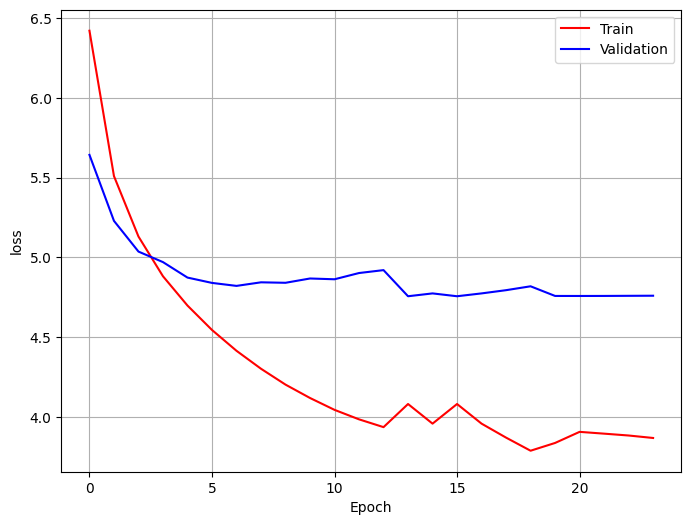

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

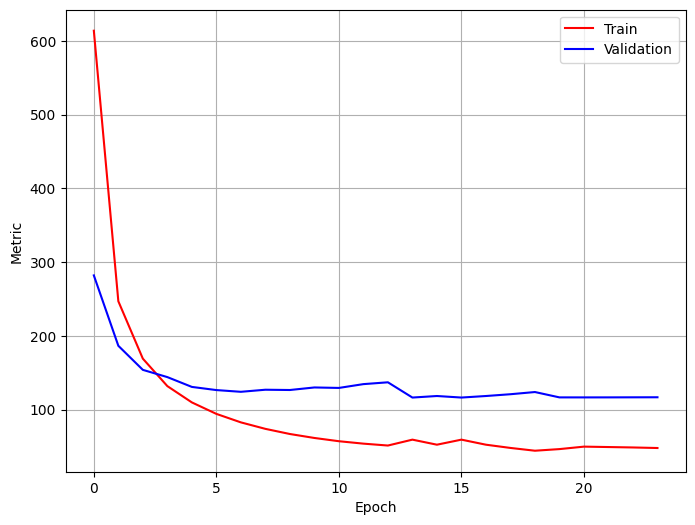

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), metric_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), metric_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.grid(True)
plt.legend()

# **10. Test**

In [ ]:
model_path = '/content/model_1_WeightTying_SecondT.pt'
model = torch.load(model_path)
model.eval()

LanguageModel(
  (embedding): Embedding(28782, 400)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstms): ModuleList(
    (0): LSTM(400, 1150, batch_first=True)
    (1): LSTM(1150, 1150, batch_first=True)
    (2): LSTM(1150, 400, batch_first=True)
  )
  (fc): Linear(in_features=400, out_features=28782, bias=True)
)

In [ ]:
loss_test, metric_test = evaluate(model, test_loader, loss_fn, metric)

In [ ]:
loss_test, metric_test

(4.708755150890212, 110.91399383544922)

# **11. Generate**

🔰 Your mission is to write a `generate` function and use a desired sentence to evaluate the model

In [ ]:
model_path = '/content/model_1_WeightTying_SecondT.pt'
model = torch.load(model_path)
model.eval()

LanguageModel(
  (embedding): Embedding(28782, 400)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstms): ModuleList(
    (0): LSTM(400, 1150, batch_first=True)
    (1): LSTM(1150, 1150, batch_first=True)
    (2): LSTM(1150, 400, batch_first=True)
  )
  (fc): Linear(in_features=400, out_features=28782, bias=True)
)

In [ ]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):
  if seed is not None:
    torch.manual_seed(seed)

  indices = vocab(tokenizer(prompt))
  itos = vocab.get_itos()

  for i in range(max_seq_len):
    src = torch.LongTensor(indices).to(device)

    with torch.no_grad():
      prediction = model(src)

    # Method 1
    # idx = torch.argmax(prediction[-1])
    # itos = vocab.get_itos()
    # itos[idx]

    # Method 2
    probs = torch.softmax(prediction[-1]/temperature, dim=0)

    idx = vocab['<ukn>']
    while idx == vocab['<ukn>']:
      idx = torch.multinomial(probs, num_samples=1).item()

    token = itos[idx]
    prompt += ' ' + token

    if idx == vocab['.']:
      return prompt

    indices.append(idx)

  return prompt

In [ ]:
examples = ['In a galaxy far, far away, there',
            'The sun was setting in the',
            'Once upon a time, there lived a young princess named',
            'What is the meaning ',
            'in the remaining days of this year i',
            'what should i']
seed = 45
for i, example in enumerate(examples):
  print(f"example {i}:")
  print(generate(example, 35, 0.5, model, tokenizer, vocab, seed))
  print()

example 0:
In a galaxy far, far away, there are no evidence of a person who can make a more detailed approach to the ' s death .

example 1:
The sun was setting in the form of a large , small @-@ walled , curved @-@ coloured alarm , and a vertical @-@ filled head , which was used as a hole @-@ like type .

example 2:
Once upon a time, there lived a young princess named the children .

example 3:
What is the meaning  of the ' ode to the nightingale ' s composition ' .

example 4:
in the remaining days of this year i had to be the first and most successful hit in the world .

example 5:
what should i have been completely successful in the past .

